In [436]:
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns

from random import random as rnd

def buildNetwork(num):
    mat = np.zeros((num,num))
    for x in range(num):
        for y in range(x):
            if x == y: 
                continue
            dist = min((x-y)%num,(y-x)%num)
            if dist%num == 1:
                mat[x,y]=1
            else:
                mat[x,y]=-1
            #elif dist%num <=2:
            #    mat[x,y]=-1
    return nx.from_numpy_matrix(mat)

def buildRandomNetwork(num,pneg = .5):
    mat = np.zeros((num,num))
    for x in range(num):
        for y in range(num):
            if x == y: 
                continue
            if rnd() < pneg:
                mat[x,y]=-1
            else:
                mat[x,y]=1
            #elif dist%num <=2:
            #    mat[x,y]=-1
    return nx.from_numpy_matrix(mat)
                 
def calcEnergySurface(net):
    nodes = len(net.nodes())
    result = []
    for x in range(2**nodes):
        s = [i if i==1 else -1 for i in [int(i) for i in np.binary_repr(x,nodes)]]
        s.reverse()
        weight = -sum([s[u]* s[v]* edata['weight']  for u,v,edata in net.edges(data=True)])
        result.append((x,weight))
    return result

def collectEnergyStates(net):
    result = calcEnergySurface(net)
    hist = {}
    for i in result:
        if i[1] in hist:
            hist[i[1]].append(i[0])
        else: 
            hist[i[1]] = [i[0]]
    return hist

#Inspection

def inspectEnergyStates(net):
    result = collectEnergyStates(net)
    k = [k for k in result.keys()]
    k.sort()   
    for i in k:
        print("{} -> {}".format(i,result[i]))


def plotWeights(net):
    result = calcEnergySurface(g)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    states = [i[0] for i in result]
    weights = [i[1] for i in result]
    ax.bar(states,weights)
    plt.show()

def summariseWeights(net):
    result = calcEnergySurface(net)
    hist = {}
    for i in result:
        if i[1] in hist:
            hist[i[1]] = hist[i[1]]+1
        else: 
            hist[i[1]] = 1
    weights = [i for i in hist.keys()]
    counts = [i for i in hist.values()]
    fig = plt.figure()
   
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Nodes = {}'.format(net.number_of_nodes()))
    ax.bar(weights,counts)
    plt.show()
    
def measureFDC(attractor_matrix):
    # Jones & Forrest 1995
    diag = attractor_matrix.diagonal()
    best_val = min(diag)
    global_attractors = [i for i, v in enumerate(diag) if v == best_val]
    
    f = []
    d = []
    for i,j in enumerate(diag):
        if j == best_val:
            continue
        f.append(j)
        d.append(min([hamming(i,g) for g in global_attractors]))
    
    return f,d,pearsonr(f,d)    


# Interesting to look at, and would be curious to see if 
# there is a fractal attractor here.  What is the set of all energy states?
def inspectAttractorMap(_min,_max):
    levels = []
    values = []   
    for nodes in range(_min,_max):
        
        net = buildNetwork(nodes)
        result = calcEnergySurface(net)
        seen = set()
        for i in result:
            if not (i[1] in seen):
                levels.append(nodes)
                values.append(i[1])
    
    fig = plt.figure()
   
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Energy levels from {} - {}'.format(_min,_max))
    ax.scatter(levels,values)
    plt.show()
    

def showMatrixHeatmap(mat):
    sns.set(rc={'figure.figsize':(17,15)})
    sns.heatmap(mat,center=.5,cmap="YlGnBu")
    
    
# Deriving the transition matrix
def hamming(a,b):
    return(bin(a^b).count("1"))

def buildAttractorMatrix(net):
    weight = dict(calcEnergySurface(net))
    mx,mn = max(weight.values()),min(weight.values())
    # Remembering here that we're looking for *low* energy states, hence the subtract from 1
    scaled = [1-(weight[w]-mn)/(mx-mn) for w in range(len(weight))]
    mat = [scaled] * len(scaled)
    return(np.array(mat)) 

def buildInertialMatrix(bits,width,weight = 1):
    inertia_matrix = np.zeros((2**bits,2**bits))
    for row_st, row in enumerate(inertia_matrix):
        for col_st, col in enumerate(row):
            bits_difference = hamming(row_st, col_st)
            inertia_matrix[row_st, col_st] = max(0, 1- bits_difference *(1/width))
    return inertia_matrix*weight
    



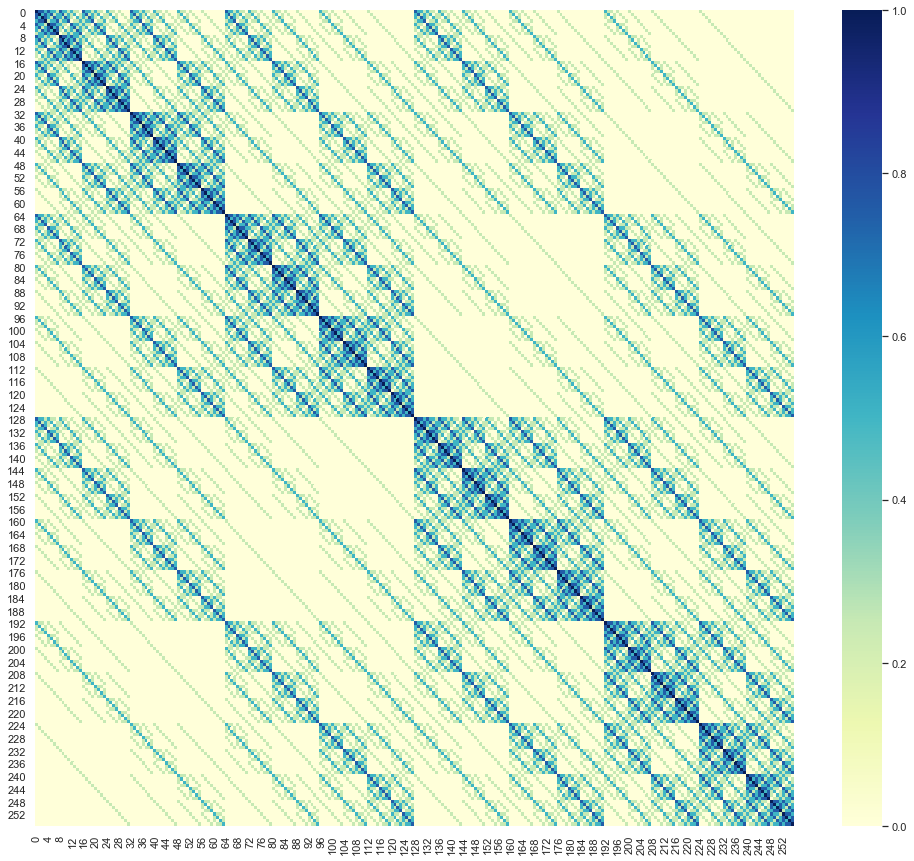

In [248]:
i_mat = buildInertialMatrix(8,4)
showMatrixHeatmap(i_mat)


# Next step: turn row into matrix, and then overlay inertial dampening

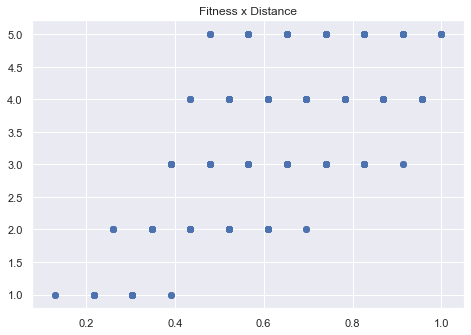

Correlation (0.6238074428359238, 2.714119831537345e-111)


In [421]:
net = buildRandomNetwork(10,.8)
att_m = buildAttractorMatrix(net)
f,d,r = measureFDC(att_m)
fig = plt.figure()
   
ax = fig.add_axes([0,0,1,1])
ax.set_title('Fitness x Distance')
ax.scatter(f,d)
plt.show()

print("Correlation {}".format(r))

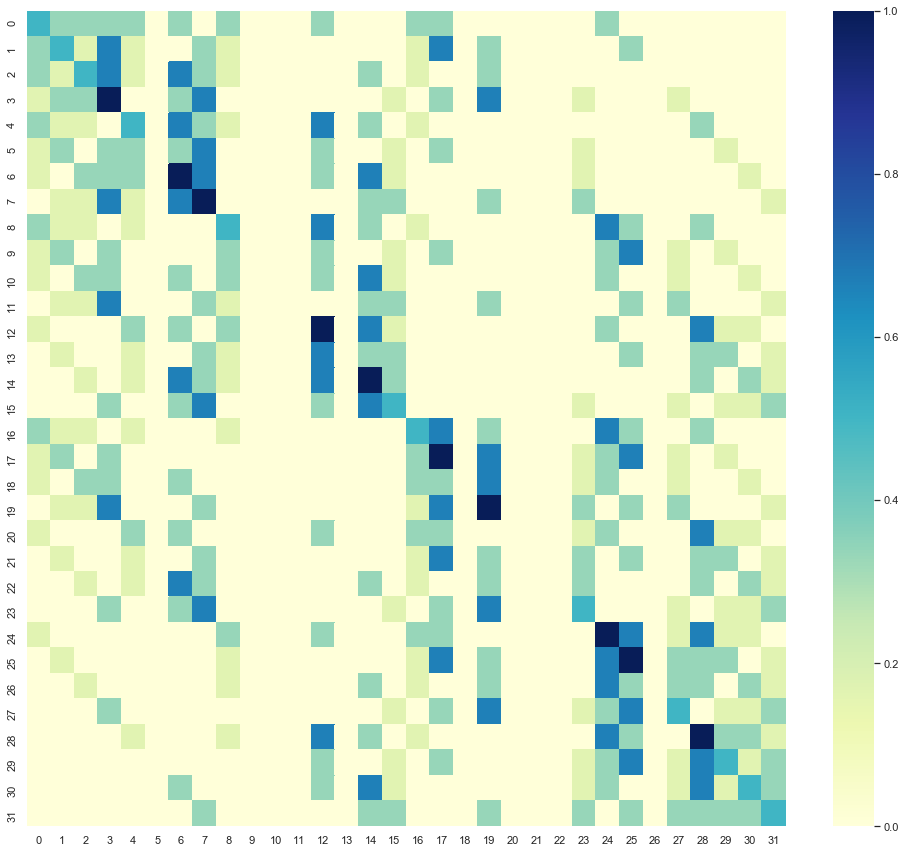

In [245]:
combined = a_mat * i_mat
showMatrixHeatmap(combined)

In [437]:
data = []
for x in range(1,20):
    local = []
    for rep in range(50):
        net = buildRandomNetwork(10,x/20)
        att_m = buildAttractorMatrix(net)
        f,d,r = measureFDC(att_m)
        local.append(r[0])
    #print("{}".format(local))
    data.append((x/20,np.mean(local)))

print(data)


[(0.05, 0.6347737941002931), (0.1, 0.48768824362278196), (0.15, 0.4107904804337582), (0.2, 0.38196561977410065), (0.25, 0.3878002583437477), (0.3, 0.40615105033753296), (0.35, 0.4218508718959991), (0.4, 0.43181822523507735), (0.45, 0.4324057798622931), (0.5, 0.4326869248086603), (0.55, 0.43198466969048693), (0.6, 0.4585998536147033), (0.65, 0.4368869805198875), (0.7, 0.4563407940943586), (0.75, 0.5023470167070889), (0.8, 0.5589771253876447), (0.85, 0.6476371704698403), (0.9, 0.745449828090144), (0.95, 0.8330548177203546)]


In [138]:
x = dict([(1,2),(3,4)])
max(x.values())

4

SyntaxError: invalid syntax (<ipython-input-110-b9c81b7ec828>, line 1)

In [423]:
x = [1,2,3,4,5]
np.mean(x)

3.0

In [305]:
from scipy.stats import pearsonr 
x = [1,2,3,4]
y=[5,4,3,2]
pearsonr(x,y)[0]

-1.0